## 用卷积神经网络训练Cifar10
For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

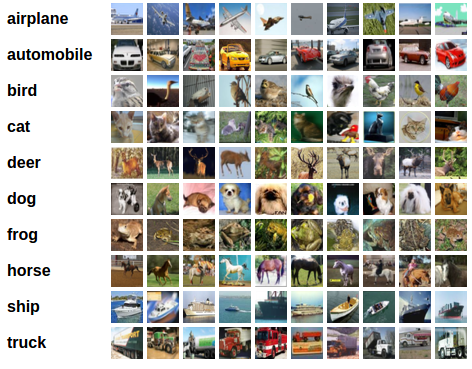

## Training an image classifier
We will do the following steps in order:
- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

## 1. Load and normalize CIFAR10
Using torchvision, it's extremely easy to load CIFAR10.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# 下载数据要加下面这两行
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import torch
import torchvision
import torchvision.transforms as transforms
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0a0+git2040069-dtk2210  Device: cuda


The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

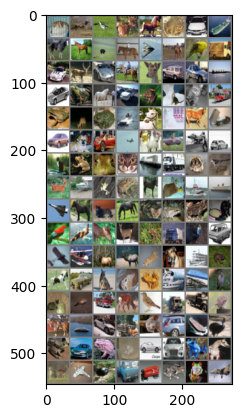

cat   deer  bird  deer  horse frog  car   ship  horse horse bird  horse plane horse bird  truck car   deer  car   horse deer  car   car   ship  car   frog  horse car   frog  cat   cat   truck frog  deer  frog  ship  horse cat   horse truck car   dog   car   plane cat   bird  plane car   cat   frog  frog  cat   ship  truck dog   bird  deer  ship  frog  frog  horse cat   ship  ship  plane horse horse horse cat   frog  frog  cat   bird  plane deer  deer  frog  truck bird  car   plane plane deer  deer  cat   dog   ship  frog  horse car   dog   cat   frog  ship  plane bird  cat   bird  truck deer  bird  truck truck bird  horse ship  car   truck dog   car   ship  bird  frog  car   frog  dog   car   car   frog  horse deer  plane bird  truck truck cat   frog  plane


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Define a Convolutional Neural Network


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SELayer(nn.Module):
    def __init__(self, channel, reduction=64):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) 
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False), 
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)     
        y = self.fc(y).view(b, c, 1, 1)     
        return x * y.expand_as(x) 

class BasicBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, reduction=16):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu=nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SELayer(out_channels, reduction)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        
        out=self.bn1(x)
        out=self.relu(out)
        out=self.conv1(out)
        out=self.bn2(out)
        out = self.relu(out)
        out=self.conv2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        
        return out
    
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=10):
        super(ResNet,self).__init__()
        self.in_channels=64
        self.conv1=nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn=nn.BatchNorm2d(64)
        self.relu=nn.ReLU(inplace=True)
        self.layer1=self.make_layer(block,64,layers[0])
        self.layer2=self.make_layer(block,128,layers[1])
        self.layer3=self.make_layer(block,256,layers[2],2)
        self.layer4=self.make_layer(block,512,layers[3],2)
        self.avg_pool=nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
                )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)
    
    def forward(self,x):
        out=self.conv1(x)
        out=self.bn(out)
        out=self.relu(out)
        out=self.layer1(out)
        out=self.layer2(out)
        out=self.layer3(out)
        out=self.layer4(out)
        out=self.avg_pool(out)
        out=torch.flatten(out,1)
        out=self.fc(out)
        return out

net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SELayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
    )
    (1): BasicBlock(
 

## 3. Define a Loss function and optimizer
Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0006, momentum=0.9)

## 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
def train(epoch, log_interval=200):
    # Set model to training mode
    net.train()
    
    # Loop over each batch from the training set
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        # Copy data to GPU if needed
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        # Pass data through the network
        output = net(inputs)
        # Calculate loss
        loss = criterion(output, labels)
        # Backpropagate
        loss.backward()  
        # Update weights
        optimizer.step()    #  w - alpha * dL / dw
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx) * len(inputs), len(trainloader.dataset),
                100. * (batch_idx) / len(trainloader), loss.data.item()))

In [7]:
def validate(loss_vector, accuracy_vector):
    net.eval()
    val_loss, correct = 0, 0
    for data, target in testloader:
        data = data.to(device)
        target = target.to(device)
        output = net(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(testloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(testloader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(testloader.dataset), accuracy))


In [8]:
%%time
epochs = 20

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.342927
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.679920

Test set: Average loss: 1.5100, Accuracy: 4459/10000 (45%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.471020
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.360466

Test set: Average loss: 1.3347, Accuracy: 5166/10000 (52%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.371452
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.294117

Test set: Average loss: 1.2508, Accuracy: 5442/10000 (54%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.088838
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.125792

Test set: Average loss: 1.2010, Accuracy: 5659/10000 (57%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.156599
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.937951

Test set: Average loss: 1.1509, Accuracy: 5837/10000 (58%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.145704
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.983977

Test set: Average loss: 1.0599, Accuracy: 6127/10000 (61%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.948188
Train Epoch: 7 [256

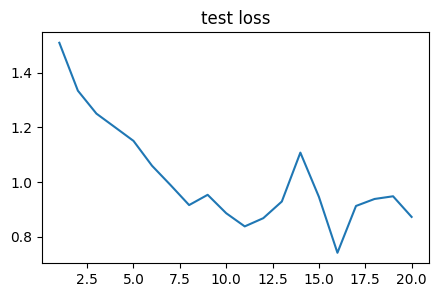

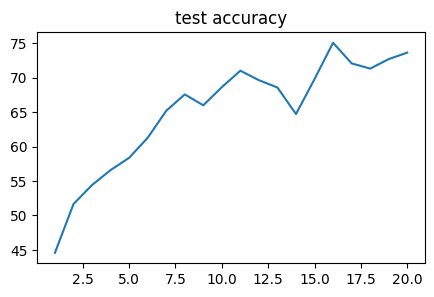

In [9]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('test loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('test accuracy');

Let’s quickly save our trained model:

In [10]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

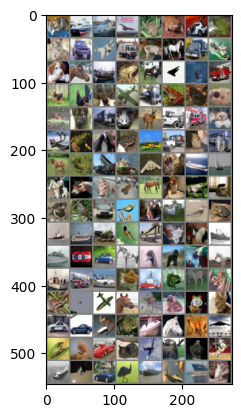

GroundTruth:  cat   ship  ship  plane


In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Next, let’s load back in our saved model (note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):

In [12]:
net = ResNet(BasicBlock, [2, 2, 2, 2])
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

In [13]:
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')